In [94]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gmean
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [95]:
df = pd.read_csv('../results/result.csv')
df = df[df.run >= 3].copy()
df['speed'] = df['sim-cycles'] / df['time']
df['ipc'] = df['instructions'] / df['cycles']
df['MPKI'] = df['cache-misses'] / df['instructions'] * 1000
df

,simulator,benchmark,sim-cycles,run,time,all_data_cache_accesses,cache-misses,cycles,instructions,speed,ipc,MPKI
3,vcs,RocketChip,100000,3,4712041,6.137378e+09,856133511.0,9.792206e+09,1.115683e+10,0.021222,1.139358,76.736263
4,vcs,RocketChip,100000,4,4756667,6.148032e+09,860573828.0,9.888645e+09,1.115723e+10,0.021023,1.128287,77.131487
5,vcs,RocketChip,100000,5,4699768,6.123101e+09,856021529.0,9.761067e+09,1.115717e+10,0.021278,1.143028,76.723874
6,vcs,RocketChip,100000,6,4691251,6.120846e+09,849012182.0,9.747613e+09,1.115709e+10,0.021316,1.144597,76.096211
7,vcs,RocketChip,100000,7,4778092,6.170388e+09,872152539.0,9.934310e+09,1.115662e+10,0.020929,1.123039,78.173577
...,...,...,...,...,...,...,...,...,...,...,...,...
1545,essent,FMUL,100000,5,10477756,7.862091e+09,547135553.0,2.301457e+10,1.567729e+10,0.009544,0.681190,34.899883
1546,essent,FMUL,100000,6,10361503,7.866655e+09,544560645.0,2.275986e+10,1.567729e+10,0.009651,0.688813,34.735639
1547,essent,FMUL,100000,7,10358750,7.859020e+09,576959659.0,2.275452e+10,1.567729e+10,0.009654,0.688975,36.802260
1548,essent,FMUL,100000,8,10348775,7.870291e+09,559804707.0,2.273192e+10,1.567729e+10,0.009663,0.689660,35.708011


# Speedup

In [96]:
piv = df.pivot_table(values='speed', index='benchmark', columns='simulator')
order = [
  'SHA256',
  'StreamComp',
  'FMUL',
  'FPU',
  'Gemmini',
  'SIGMA',
  'GEMM',
  'Conv2D',
  'RISCVMini',
  'RocketCore',
  'SodorCore',
  'RocketChip',
  # 'RocketChipTiny'
]
sim_order = [
  'circt-verilator', 'verilator-1', 'verilator-2', 'verilator-4', 'ksim', 'ksim-nogate', 'repcut-1', 'repcut-2', 'repcut-4', 'repcut-6', 'vcs'
]
baseline_name = 'circt-verilator'
baseline = piv[baseline_name].copy()
for col in piv:
  piv[col] /= baseline

In [97]:
df_stat = pd.read_csv('../results/size.csv').set_index('name').loc[order]

In [98]:
df_stat

,num-edges,num-ops,num-dce'd,all-regs,fused-clock-gate,num-cse'd
name,,,,,,
SHA256,657,305,1,42,9,2
StreamComp,75896,38417,1,403,6,4
FMUL,23276,12062,73,755,648,4
FPU,5337,2881,78,119,98,50
Gemmini,135076,78613,2,416,172,800
SIGMA,28998,17364,1,291,100,284
GEMM,11704,5015,1,1632,98,1286
Conv2D,17820,7599,1,1969,128,754
RISCVMini,3548,1670,5,62,10,386


In [99]:
(df_stat['fused-clock-gate'] / df_stat['all-regs'])

name
SHA256        0.214286
StreamComp    0.014888
FMUL          0.858278
FPU           0.823529
Gemmini       0.413462
SIGMA         0.343643
GEMM          0.060049
Conv2D        0.065008
RISCVMini     0.161290
RocketCore    0.000000
SodorCore     0.100000
RocketChip    0.330124
dtype: float64

In [100]:
piv = piv.stack().loc[order].reset_index(name='speedup')
piv = piv.set_index('benchmark').reset_index()
def mark_npos(bar, y, *args, **kws):
  npos = []
  for c in bar.containers:
    for child in c.get_children():
      if np.isnan(child.get_height()):
        center = child.get_x() + child.get_width() / 2
        npos.append(center)
  xlim = plt.xlim()
  plt.plot(npos, np.full(len(npos), y), *args, **kws)
  plt.xlim(xlim)

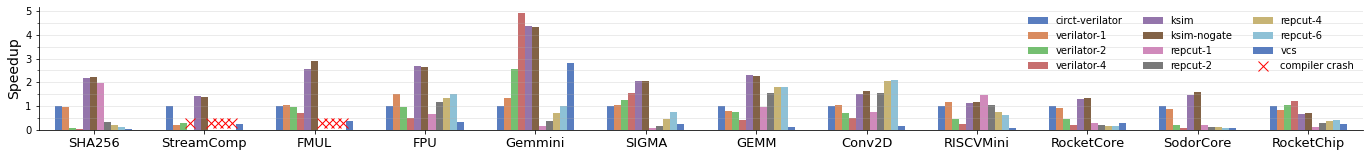

In [101]:
plt.figure(figsize=(20, 2.5))
bar = sns.barplot(
  data=piv,
  x='benchmark', y='speedup',
  hue='simulator', hue_order=sim_order,
  palette='muted',
  width=0.7,
)
# set_hatch(bar)
# for c in bar.containers:
#   bar.bar_label(c, fmt='$%.1f$', fontsize=10)
mark_npos(bar, 0.3, 'rx', markersize=10, label='compiler crash')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=3, frameon=False)
# plt.xticks(fontsize=13, rotation=-15, ha='left')
plt.xticks(fontsize=13)
plt.xlabel(None)
# plt.ylim([0, 5])
plt.ylabel('Speedup', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0))
plt.grid(axis='y', alpha=0.3)
plt.grid(axis='y', which='minor', alpha=0.3)
sns.despine()
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.draw()

In [104]:
1.80 / 2

0.9

In [103]:
df.pivot_table(values='speed', columns='simulator', index='benchmark', aggfunc='mean').mean()

simulator
circt-verilator    1.011615
essent             0.802863
ksim               1.809885
ksim-nogate        2.004178
repcut-1           1.500966
repcut-2           0.504010
repcut-4           0.411360
repcut-6           0.363552
repcut-8           0.307058
vcs                0.076623
verilator-1        0.944040
verilator-2        0.250344
verilator-4        0.153552
dtype: float64

In [90]:
piv_abs = df.pivot_table(values='speed', columns='simulator', index='benchmark', aggfunc='mean')
baseline_name = 'circt-verilator'
baseline = piv_abs[baseline_name].copy()
piv = piv_abs.apply(lambda x: x / baseline)
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.2f}')

simulator,circt-verilator,essent,ksim,ksim-nogate,repcut-1,repcut-2,repcut-4,repcut-6,repcut-8,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,1.00,0.15,1.73,1.77,0.77,1.57,2.06,2.12,1.97,0.16,1.06,0.70,0.48
FMUL,1.00,0.11,2.52,2.38,nan,nan,nan,nan,nan,0.36,1.03,0.95,0.71
FPU,1.00,1.01,2.71,2.71,0.66,1.17,1.34,1.49,1.14,0.32,1.51,0.97,0.48
GEMM,1.00,0.26,2.13,2.34,0.96,1.54,1.80,1.81,1.61,0.14,0.79,0.74,0.43
Gemmini,1.00,0.44,4.55,4.52,0.18,0.35,0.71,1.01,1.24,2.82,1.34,2.58,4.91
RISCVMini,1.00,0.42,1.83,1.83,1.48,1.05,0.75,0.63,0.56,0.08,1.17,0.44,0.23
RocketChip,1.00,25.07,0.68,0.68,0.14,0.27,0.38,0.42,0.32,0.25,0.82,1.05,1.22
RocketChipTiny,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
RocketCore,1.00,1.58,1.40,1.42,0.30,0.21,0.15,0.14,0.11,0.27,0.91,0.44,0.21


# IPC

In [37]:
piv = df.pivot_table(values='ipc', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,repcut-6,repcut-8,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,
Conv2D,1.844,1.088,3.027,1.832,1.574,1.040,0.720,0.504,2.303,1.871,0.634,0.274
FMUL,1.910,0.691,3.043,nan,nan,nan,nan,nan,2.716,1.928,0.953,0.417
FPU,3.618,2.580,3.759,1.836,1.663,0.980,0.792,0.569,2.491,3.114,1.178,0.367
GEMM,1.737,1.800,3.034,2.176,1.442,0.875,0.603,0.398,2.339,1.365,0.604,0.225
Gemmini,2.965,0.512,3.398,0.526,0.526,0.521,0.499,0.459,2.041,2.579,2.433,2.311
RISCVMini,2.000,2.461,3.577,2.699,1.239,0.612,0.435,0.337,2.618,2.145,0.606,0.243
RocketChip,2.216,0.751,1.973,0.672,0.832,0.705,0.621,0.446,1.125,1.816,1.343,0.985
RocketChipTiny,nan,0.831,2.414,0.809,1.134,0.729,0.356,0.273,1.614,2.253,0.880,0.400
RocketCore,2.414,2.721,3.133,1.487,0.824,0.514,0.410,0.347,2.580,2.156,0.644,0.229


# Cycles

In [38]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [39]:
piv = df.pivot_table(values='cycles', columns='simulator', index='benchmark', aggfunc='mean')
# piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,repcut-6,repcut-8,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,
Conv2D,853.5 M,6.0 G,506.0 M,1.1 G,1.1 G,1.7 G,2.4 G,3.6 G,4.1 G,807.5 M,2.4 G,7.1 G
FMUL,2.4 G,22.7 G,937.1 M,None,None,None,None,None,6.3 G,2.4 G,5.2 G,13.7 G
FPU,453.5 M,457.6 M,168.2 M,686.4 M,771.0 M,1.4 G,1.8 G,3.4 G,877.1 M,301.2 M,936.0 M,3.8 G
GEMM,651.5 M,2.6 G,294.8 M,680.9 M,842.6 M,1.4 G,2.2 G,3.4 G,4.1 G,821.9 M,1.8 G,6.1 G
Gemmini,12.5 G,29.4 G,2.8 G,71.3 G,71.0 G,70.5 G,74.7 G,81.1 G,3.9 G,9.4 G,9.7 G,10.2 G
RISCVMini,197.3 M,484.5 M,105.7 M,134.2 M,375.3 M,1.0 G,1.9 G,3.0 G,766.2 M,168.7 M,878.5 M,3.4 G
RocketChip,3.1 G,31.4 G,4.1 G,19.3 G,20.1 G,29.3 G,40.3 G,69.7 G,9.9 G,6.2 G,8.5 G,12.0 G
RocketChipTiny,None,9.9 G,1.3 G,5.6 G,4.0 G,6.6 G,18.6 G,26.9 G,3.7 G,869.5 M,2.5 G,7.1 G
RocketCore,459.8 M,288.6 M,325.8 M,1.5 G,4.3 G,12.4 G,19.6 G,33.1 G,1.1 G,504.5 M,2.1 G,8.6 G


# Instructions

In [40]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [41]:
piv = df.pivot_table(values='instructions', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,repcut-6,repcut-8,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,
Conv2D,1.6 G,6.6 G,1.5 G,2.0 G,1.7 G,1.7 G,1.7 G,1.8 G,9.4 G,1.5 G,1.5 G,1.9 G
FMUL,4.7 G,15.7 G,2.9 G,None,None,None,None,None,17.1 G,4.6 G,4.9 G,5.7 G
FPU,1.6 G,1.2 G,632.4 M,1.3 G,1.3 G,1.3 G,1.4 G,1.9 G,2.2 G,938.1 M,1.1 G,1.4 G
GEMM,1.1 G,4.7 G,894.6 M,1.5 G,1.2 G,1.3 G,1.3 G,1.3 G,9.7 G,1.1 G,1.1 G,1.4 G
Gemmini,37.2 G,15.0 G,9.3 G,37.5 G,37.3 G,36.8 G,37.3 G,37.2 G,8.0 G,24.1 G,23.6 G,23.6 G
RISCVMini,394.6 M,1.2 G,378.1 M,362.1 M,465.0 M,638.7 M,808.7 M,1.0 G,2.0 G,361.6 M,532.3 M,829.5 M
RocketChip,6.8 G,23.6 G,8.0 G,13.0 G,16.7 G,20.6 G,25.0 G,31.0 G,11.2 G,11.2 G,11.4 G,11.8 G
RocketChipTiny,None,8.2 G,3.0 G,4.5 G,4.5 G,4.8 G,6.6 G,7.3 G,6.0 G,2.0 G,2.2 G,2.8 G
RocketCore,1.1 G,785.4 M,1.0 G,2.2 G,3.5 G,6.4 G,8.0 G,11.1 G,2.9 G,1.1 G,1.3 G,2.0 G


# MPKI

In [42]:
piv = df.pivot_table(values='MPKI', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,repcut-6,repcut-8,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,
Conv2D,0.021,8.557,0.015,0.023,5.815,10.683,14.916,15.691,1.929,0.023,41.096,77.094
FMUL,0.009,36.711,0.008,nan,nan,nan,nan,nan,1.668,0.017,3.680,12.811
FPU,0.018,0.017,0.030,0.019,2.756,6.281,8.590,6.879,0.947,0.032,7.506,23.907
GEMM,0.028,13.055,0.022,0.018,12.685,21.592,27.069,28.141,0.606,0.029,41.094,96.730
Gemmini,12.866,68.468,5.199,47.938,32.172,3.360,1.264,2.219,0.902,10.402,3.983,4.535
RISCVMini,0.068,0.019,0.051,0.053,6.832,13.469,16.286,14.999,1.036,0.081,17.154,42.944
RocketChip,1.589,69.648,22.821,44.411,3.824,1.217,1.147,1.524,77.203,0.511,5.512,10.957
RocketChipTiny,nan,23.660,0.014,6.788,1.005,2.348,2.462,2.919,23.242,0.019,17.450,32.199
RocketCore,0.027,0.030,0.020,0.019,1.661,2.072,2.634,2.543,0.715,0.029,21.187,54.457
